In [2]:
import pickle
import warnings
from datetime import datetime
from functools import partial
from itertools import repeat

import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from library.classes import Feature, ManageDataSplit, ManageFeatures, feature_objects
from library.feature_func import (
    add_categorical_feature,
    add_feature_targets_groupby_stats,
    add_numerical_feature,
    f_rolling_mean,
    f_shifted,
    time_arrow,
    f_microbusiness_pct_change,
    f_microbusiness_density_diff,
)
from library.optimize_this import optimize_this
from library.utils import build_callbacks, read_df, smape, ztransform2, inverseZ2

# print the JS visualization code to the notebook
shap.initjs()

objective = "mae"

In [3]:
# df_census = read_df("census_starter.csv")
df_test = read_df("test.csv")
df_train = read_df("train.csv")
df_submission = read_df("sample_submission.csv")
# df_population = read_df('df_population.csv', 'other')
# df_census_population = read_df('df_census_population.csv', 'kaggle_census')
# df_train_census = read_df('df_train_census.csv', 'kaggle_census')
df_adjusted_microbusiness_density = read_df('df_adjusted_microbusiness_density.csv', 'kaggle_census')

# df_boundaries = read_df("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")
df_train = pd.merge(df_train, df_adjusted_microbusiness_density, 'left', 'row_id')
df_train = df_train.rename(
    columns={
        "microbusiness_density": "original_microbusiness_density",
        "adjusted_microbusiness_density": "microbusiness_density",
    }
)
df_train['microbusiness_density'] = df_train['microbusiness_density'].apply(np.log1p)

# df_train = df_train.rename(
#     columns={
#         "microbusiness_density": "original_microbusiness_density",
#         "active": "microbusiness_density",
#     }
# )
df_location = read_df('cfips_location.csv', 'usa-counties-coordinates')

In [4]:
manage_data_split = ManageDataSplit(df_train)

enabled_tuple = (0, 0.55)
enabled_tuple_h = (0, 0.75)
enabled_tuple_almost = (0.4, 1)
enabled_tuple_always = (1, 1)
params_tuple = (0, 10)

gamma = 0

# Better to clear it. Otherwise it might containt features we do not want
feature_objects.clear()

for cols in [
    {
        "target_col": "microbusiness_density",
        "groupby_col": "cfips",
        "params_bounds": list(repeat((1, 12), 4)),
    },
    # {"target_col": "microbusiness_density", "groupby_col": "county"},
    # {"target_col": "microbusiness_density", "groupby_col": "state"},
]:
    target_col = cols["target_col"]
    groupby_col = cols["groupby_col"]
    params_bounds = list(repeat((1, 20), 4))
    if "params_bounds" in cols.keys():
        params_bounds = cols["params_bounds"]
    f_col = "{}_{}_rolling_mean".format(groupby_col, target_col)
    feature_target_rolling_mean = Feature(
        f_col,
        f_rolling_mean,
        df_train,
        target_col=target_col,
        groupby_col=groupby_col,
        enabled_bounds=list(repeat(enabled_tuple, 4)),
        params_bounds=params_bounds,
    )


target_col = "microbusiness_density"
params_bounds = list(repeat((2, 10), 4))
params_bounds[0] = (1, 1+gamma)
enabled_bounds = list(repeat(enabled_tuple, 4))
enabled_bounds[0] = enabled_tuple_always
feature_target_shift_mean = Feature(
    f_col="{}_shift".format(target_col),
    f=f_shifted,
    df=df_train,
    target_col=target_col,
    enabled_bounds=enabled_bounds,
    params_bounds=params_bounds,
)

target_col = "original_microbusiness_density"
params_bounds = list(repeat((2, 10), 4))
enabled_bounds = list(repeat(enabled_tuple, 4))
params_bounds[0] = (1, 1+gamma)
enabled_bounds[0] = enabled_tuple_always
params_bounds[1] = (2, 2+gamma)
enabled_bounds[1] = enabled_tuple_almost
feature_target_shift_mean = Feature(
    f_col="{}_shift".format(target_col),
    f=f_shifted,
    df=df_train,
    target_col=target_col,
    enabled_bounds=enabled_bounds,
    params_bounds=params_bounds,
)

for idx, col in enumerate(
    [
        ("county", enabled_tuple_almost),
        "state",
        ("cfips", enabled_tuple_almost),
    ]
):
    _tuple = enabled_tuple
    if type(col) is not str:
        _tuple = col[1]
        col = col[0]
    _feature = Feature(col, add_categorical_feature, df_train, enabled_bounds=[_tuple])

for idx, col in enumerate(
    [
        "median_hh_inc",
        "pct_bb",
        "pct_college",
        "pct_foreign_born",
        "pct_it_workers",
        ("target_census_over_18_population_x1000", enabled_tuple_almost),
        ("target_census_population_x1000", enabled_tuple_almost),
        "lng",
        "lat",
        "rot_15_x",
        "rot_15_y",
        "rot_30_x",
        "rot_30_y",
        "rot_45_x",
        "rot_45_y",
    ]
):
    _tuple = enabled_tuple
    if type(col) is not str:
        _tuple = col[1]
        col = col[0]
    _feature = Feature(col, add_numerical_feature, df_train, enabled_bounds=[_tuple])

feature_time_arrow = Feature(
    "time_arrow", time_arrow, df_train, enabled_bounds=[enabled_tuple]
)

# for groupby_col in [
#     "cfips",
#     "state",
#     "county",
# ]:
#     for col in [
#         "median_hh_inc",
#         "pct_bb",
#         "pct_college",
#         "pct_foreign_born",
#         "pct_it_workers",
#     ]:
#         for agg_function in ["median", "mean", "std"]:
#             f_col = "{}_{}_target_{}".format(groupby_col, col, agg_function)
#             _feature = Feature(
#                 f_col,
#                 add_feature_targets_groupby_stats,
#                 df_train,
#                 groupby_col=groupby_col,
#                 col=col,
#                 agg_function=agg_function,
#                 enabled_bounds=[enabled_tuple],
#                 train_idx=manage_data_split._train_idx,
#             )

feature_microbusiness_density_pct_change = Feature(
    "microbusiness_density_pct_change",
    f_microbusiness_pct_change,
    df_train,
    enabled_bounds=[enabled_tuple],
)

feature_microbusiness_density_diff = Feature(
    "microbusiness_density_diff",
    f_microbusiness_density_diff,
    df_train,
    enabled_bounds=[enabled_tuple],
)

# Bounded region of parameter space
model_pbounds = {
    "num_leaves": (3, 200),
    "num_iterations": (2000, 2000),
    "learning_rate": (0.01, 2.5),
    "bagging_fraction": (0.0001, 1),
    "feature_fraction": (0.0001, 1),
    "lambda_l1": (0, 500),
    "lambda_l2": (0, 500),
    "bagging_freq": (0, 500),
    "min_data_in_leaf": (10, 3000),
    "min_sum_hessian_in_leaf": (0, 500),
    "max_depth": (-10, 150),
    "path_smooth": (0, 500),
}

In [5]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

pbounds = {**pbounds, 'lower_quantile': (0, 0.01), 'upper_quantile': (0.98, 1)}

# pbounds = {**pbounds, 'lower_quantile': (0, 0.2), 'upper_quantile': (0.8, 1)}

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)
# acquisition_function = UtilityFunction(kind="ucb", kappa=1)
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

objective = "mae"
optimize_this_partial = partial(
    optimize_this,
    objective=objective,
    pbounds=pbounds,
    manage_data_split=manage_data_split,
    manage_features=manage_features,
    df_train=df_train,
    build_callbacks=build_callbacks,
    target_shift=0,
)

optimizer = BayesianOptimization(
    f=optimize_this_partial,
    pbounds=pbounds,
    verbose=0,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
    # n_restarts_optimizer=50,
    # bounds_transformer=bounds_transformer
)
# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

load_logs(optimizer, logs=['../data/bayesian_optimizer/2023-03-08_02-29-47_logs.json']);

dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# optimizer.maximize(
#     init_points=1,
#     n_iter=1,
#     # acquisition_function=acquisition_function
# )

print(optimizer.max['target'])

-1.2005148029551684


In [105]:
(
    gbm,
    lgb_train,
    lgb_eval,
    lgb_test,
    model_params,
    callbacks,
    df_features,
    df_target,
) = optimize_this_partial(
    objective="l2", return_booster=True, **optimizer.max["params"]
)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(lgb_test.data)

l2 np.expm1 train(80862, 7) test(15675, 7) -3.8356 eval(25080, 7) -2.21


In [106]:
df_train['microbusiness_density'].apply(np.expm1).describe()

count    128535.000000
mean          3.786961
std           4.951633
min           0.000000
25%           1.667386
50%           2.602011
75%           4.483468
max         259.072515
Name: microbusiness_density, dtype: float64

In [107]:
param = 0.001

X_train = lgb_train.data.copy()
y_train = np.expm1(lgb_train.label.copy())
# y_train = y_train * 0.9
# y_train = ztransform2(y_train, param)

X_eval = lgb_eval.data.copy()
y_eval = np.expm1(lgb_eval.label.copy())
# y_eval = ztransform2(y_eval, param)

X_test = lgb_test.data.copy()
y_test = np.expm1(lgb_test.label.copy())
# y_test = ztransform2(y_test, param)

lgb_train_exp = lgb.Dataset(X_train, y_train)
lgb_eval_exp = lgb.Dataset(X_eval, y_eval, reference=lgb_train_exp)
lgb_test_exp = lgb.Dataset(X_test, y_test, reference=lgb_eval_exp)

In [108]:
# model_params['metric'] = 'l2'

In [ ]:
gbm = lgb.train(
    model_params,
    lgb_train_exp,
    callbacks=callbacks,
    valid_sets=[lgb_eval_exp],
    feval=smape,
)
gbm.best_score

In [113]:
df_lgb_test = lgb_test_exp.data.copy()
df_lgb_test['pred'] = gbm.predict(lgb_test_exp.data)
df_lgb_test['label'] = lgb_test_exp.label
# df_lgb_test['pred'] = inverseZ2(df_lgb_test['pred'], param)
# df_lgb_test['label'] = inverseZ2(df_lgb_test['label'], param)

In [131]:
smape(df_lgb_test['pred']*0.999, df_lgb_test['label'])

('smape', 2.948820483233696, False)

In [123]:
smape(df_lgb_test['pred'], df_lgb_test['label'])

('smape', 2.9472924943379875, False)

In [7]:
df_lgb_test = lgb_test.data.copy()
df_lgb_test['pred'] = gbm.predict(lgb_test.data)
df_lgb_test['label'] = lgb_test.label

In [9]:
smape(df_lgb_test['pred'], df_lgb_test['label'])

('smape', 1.2005148029551684, False)

In [10]:
smape(df_lgb_test['pred'].apply(np.expm1), df_lgb_test['label'].apply(np.expm1))

('smape', 2.1662994224715884, False)

In [6]:
df_optimizer_params = pd.DataFrame([x["params"] for x in optimizer.res])
df_optimizer_target = pd.DataFrame(
    [x["target"] for x in optimizer.res], columns=["target"]
)

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

In [7]:
res = []
l_model_params = []
for idx, row in df_optimizer.sort_values("target", ascending=False).head(2).iterrows():
    d = {}
    bayes_params = optimizer.res[idx]["params"]
    gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks, df_features, df_target = optimize_this_partial(
        return_booster=True, **bayes_params
    )

    gbm = lgb.train(
        model_params,
        lgb_train,
        callbacks=callbacks,
        valid_sets=[lgb_eval],
        feval=smape,
    )

    pred = gbm.predict(lgb_test.data)
    loss = smape(pred, lgb_test.label)
    print("test loss", loss, "nr of cols:", lgb_test.data.shape[1])

    # res.append(
    #     {
    #         "df_optimizer_idx": idx,
    #         "loss": loss,
    #         "cols": lgb_test.data.columns,
    #         "bayes_params": bayes_params,
    #     }
    # )

    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(lgb_test.data)

    df_bayes_params = (
        pd.DataFrame.from_dict(bayes_params, orient="index")
        .reset_index()
        .rename(columns={0: "param"})
    )

    t5 = pd.DataFrame([lgb_test.data.columns, np.absolute(shap_values).sum(axis=0)]).T
    t5.columns = ["col", "shap_abs_value"]
    t5 = pd.merge(t5, df_bayes_params, "left", left_on="col", right_on="index")

    t5 = t5.sort_values("shap_abs_value", ascending=False)

    l_model_params.append(model_params)
    res.append(
        {
            "df_optimizer_idx": idx,
            "loss": loss,
            "cols": lgb_test.data.columns,
            "bayes_params": bayes_params,
            "t5": t5,
        }
    )

    print("-----------------------")
    print(t5["shap_abs_value"].values)

    for i in range(1, t5.shape[0]):
        cols_w_params = t5[:i]
        cols_to_use = cols_w_params["col"].values

        lgb_train_shap = lgb.Dataset(lgb_train.data[cols_to_use], lgb_train.label)
        lgb_eval_shap = lgb.Dataset(lgb_eval.data[cols_to_use], lgb_eval.label)
        lgb_test_shap = lgb.Dataset(lgb_test.data[cols_to_use], lgb_test.label)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            gbm = lgb.train(
                model_params,
                lgb_train_shap,
                callbacks=callbacks,
                valid_sets=[lgb_eval_shap],
                feval=smape,
            )

            pred = gbm.predict(lgb_test_shap.data)
            loss = smape(pred, lgb_test_shap.label)
            print("test loss", loss, "nr of cols:", lgb_test_shap.data.shape[1])
            res.append(
                {
                    "df_optimizer_idx": idx,
                    "loss": loss,
                    "cols": lgb_test_shap.data.columns,
                    "bayes_params": bayes_params,
                }
            )
    # break

mae train(75228, 16) test(15675, 16) -2.3017 eval(25080, 16) -2.3642


Found `num_iterations` in params. Will use it instead of argument


test loss ('smape', 2.3017044914386284, False) nr of cols: 16
-----------------------
[28421.292676956185 5156.689629472967 806.3921111686482 571.0719890443214
 543.4550164542375 55.12373870525869 23.639393413842246 16.61975027410959
 8.670910372824759 5.920935445699071 4.219971503740559 2.879599548725789
 1.127495476890024 1.021461006909278 0.0 0.0]
test loss ('smape', 2.300309138453332, False) nr of cols: 1
test loss ('smape', 2.300309138453332, False) nr of cols: 2
test loss ('smape', 2.2884374087188895, False) nr of cols: 3
test loss ('smape', 2.2872503125939865, False) nr of cols: 4
test loss ('smape', 2.2857569772694615, False) nr of cols: 5
test loss ('smape', 2.2974872460386337, False) nr of cols: 6
test loss ('smape', 2.307444159949363, False) nr of cols: 7
test loss ('smape', 2.313709200733366, False) nr of cols: 8
test loss ('smape', 2.3037366203315908, False) nr of cols: 9
test loss ('smape', 2.3014492660205326, False) nr of cols: 10
test loss ('smape', 2.3057875852882685, 

Found `num_iterations` in params. Will use it instead of argument


test loss ('smape', 2.321206297468831, False) nr of cols: 11
-----------------------
[34342.15047680874 689.9531486197138 176.90817462775075 157.18367541175286
 133.72093827439235 104.61074596332882 61.9330567027331 45.54361373094638
 43.68990158535759 34.24408540926976 0.0]
test loss ('smape', 2.305702460742302, False) nr of cols: 1
test loss ('smape', 2.2882641789555276, False) nr of cols: 2
test loss ('smape', 2.2873692788573536, False) nr of cols: 3
test loss ('smape', 2.2867879541785734, False) nr of cols: 4
test loss ('smape', 2.3003497154062327, False) nr of cols: 5
test loss ('smape', 2.3358533405929536, False) nr of cols: 6
test loss ('smape', 2.4728342541181325, False) nr of cols: 7
test loss ('smape', 2.4420148227197895, False) nr of cols: 8
test loss ('smape', 2.3309381929034863, False) nr of cols: 9
test loss ('smape', 2.3286450890475265, False) nr of cols: 10


In [10]:
df_res = pd.DataFrame(res)
# tr = []
# for idx, row in df_res.iterrows():
#     tr.append(row['t5'].iloc[0])
    # break

In [11]:
df_res

,df_optimizer_idx,loss,cols,bayes_params,t5
0,60,"(smape, 2.0360686961702448, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",...
1,60,"(smape, 1.9970119915941915, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
2,60,"(smape, 1.983726732360365, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
3,60,"(smape, 1.9659946361407832, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
4,60,"(smape, 1.9767433974425237, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
5,60,"(smape, 2.0415824088623604, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
6,60,"(smape, 2.037304973209586, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
7,60,"(smape, 2.0043021241914296, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
8,60,"(smape, 2.0411313828655056, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN
9,60,"(smape, 2.05124669779848, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 1.0, 'bagging_freq': 125....",NaN


In [31]:
best = df_res.sort_values('loss').iloc[4]
print(best['cols'])
# print(best['bayes_params'])
best

Index(['params_cfips_microbusiness_density_rolling_mean_0',
       'params_original_microbusiness_density_shift_0', 'cfips', 'county',
       'time_arrow', 'params_original_microbusiness_density_shift_2',
       'target_census_population_x1000'],
      dtype='object')


df_optimizer_idx                                                   60
loss                               (smape, 2.0043021241914296, False)
cols                Index(['params_cfips_microbusiness_density_rol...
bayes_params        {'bagging_fraction': 1.0, 'bagging_freq': 125....
t5                                                                NaN
Name: 7, dtype: object

In [33]:
for col in ['params_cfips_microbusiness_density_rolling_mean_0']:
    print (col, best['bayes_params'][col])

params_cfips_microbusiness_density_rolling_mean_0 1.0


In [19]:
print(best['cols'])

Index(['params_cfips_microbusiness_density_rolling_mean_0', 'params_original_microbusiness_density_shift_0'], dtype='object')


In [26]:
df_res.head(50)

,df_optimizer_idx,loss,cols,bayes_params,t5
0,2717,"(smape, 1.9928222750763727, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 0.6211303871102194, 'bagg...",...
1,2717,"(smape, 1.9257929646002476, False)",Index(['params_microbusiness_density_shift_0']...,"{'bagging_fraction': 0.6211303871102194, 'bagg...",NaN
2,2717,"(smape, 1.9154872974505843, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.6211303871102194, 'bagg...",NaN
3,2717,"(smape, 1.9122677757428237, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.6211303871102194, 'bagg...",NaN
4,2717,"(smape, 2.285647360942892, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.6211303871102194, 'bagg...",NaN
5,2717,"(smape, 1.9848216574563924, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.6211303871102194, 'bagg...",NaN
6,739,"(smape, 2.0189544316253265, False)",Index(['params_cfips_microbusiness_density_rol...,"{'bagging_fraction': 0.9697483253169006, 'bagg...",...
7,739,"(smape, 1.83975290776713, False)",Index(['params_microbusiness_density_shift_0']...,"{'bagging_fraction': 0.9697483253169006, 'bagg...",NaN
8,739,"(smape, 1.8605725118498382, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.9697483253169006, 'bagg...",NaN
9,739,"(smape, 1.853489567739671, False)","Index(['params_microbusiness_density_shift_0',...","{'bagging_fraction': 0.9697483253169006, 'bagg...",NaN


In [29]:
params = df_res.loc[7]['bayes_params']
gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks, df_features, df_target = optimize_this_partial(
    return_booster=True, **params
)

In [ ]:
l_model_params = []
for idx, row in df_res.iterrows():
    gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks = optimize_this_partial(
        return_booster=True, **row["bayes_params"]
    )
    # df_res.loc[idx, 'model_params'] = model_params
    l_model_params.append(model_params)

In [ ]:
df_model_params = pd.DataFrame(l_model_params)

In [ ]:
df_model_params

In [ ]:
idx

In [ ]:
df_res

In [ ]:
df_res.loc[3]['cols']

In [ ]:
df_res.loc[4]['cols']

In [ ]:
cols_to_use = ['params_microbusiness_density_shift_0', 'cfips_target_mean']

lgb_train_shap = lgb.Dataset(lgb_train.data[cols_to_use], lgb_train.label)
lgb_eval_shap = lgb.Dataset(lgb_eval.data[cols_to_use], lgb_eval.label)
lgb_test_shap = lgb.Dataset(lgb_test.data[cols_to_use], lgb_test.label)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    gbm = lgb.train(
        model_params,
        lgb_train_shap,
        callbacks=callbacks,
        valid_sets=[lgb_eval_shap],
        feval=smape,
    )

    pred = gbm.predict(lgb_test_shap.data)
    loss = smape(pred, lgb_test_shap.label)
    print("test loss", loss, "nr of cols:", lgb_test_shap.data.shape[1])

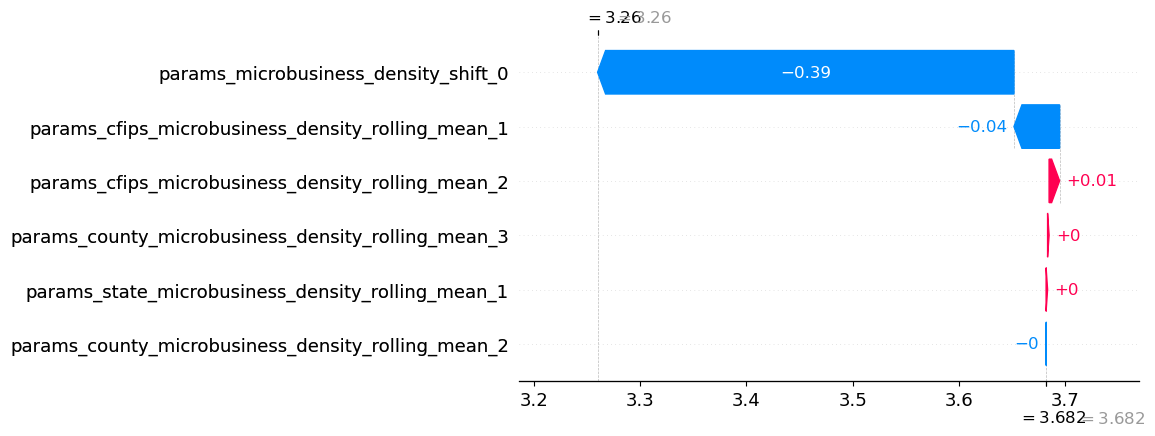

In [12]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[1],
                                            feature_names=lgb_test.data.columns, max_display=20 )

In [ ]:
set(lgb_train.data.columns) - set(lgb_train.data[cols_w_params["col"].values].columns)

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[1],
                                            feature_names=lgb_test.data.columns, max_display=20 )

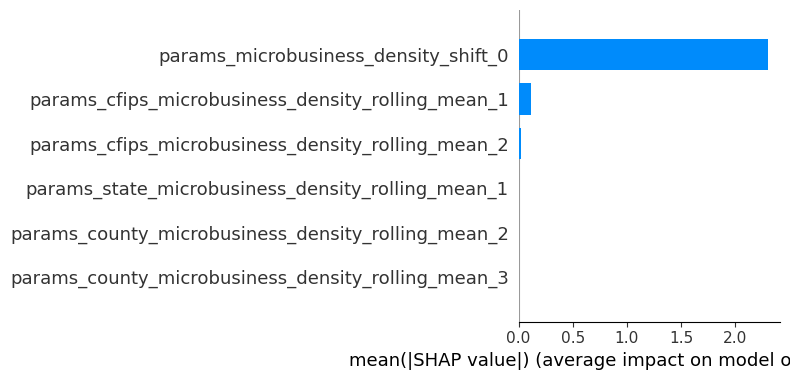

In [13]:
shap.summary_plot(shap_values, lgb_test.data, plot_type="bar", use_log_scale=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


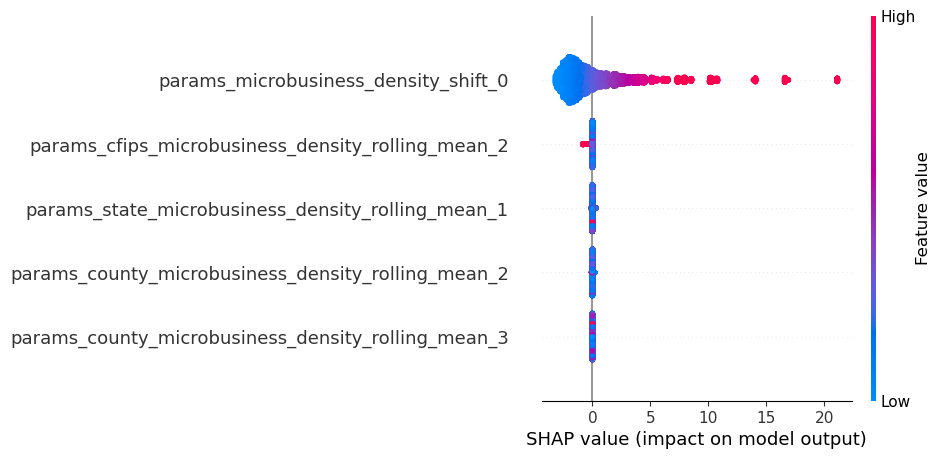

In [14]:
shap.summary_plot(shap_values[:, 1:], lgb_test.data[lgb_test.data.columns[1:]], plot_size=(5,5))

In [ ]:
bayes_params

4.470722486310596


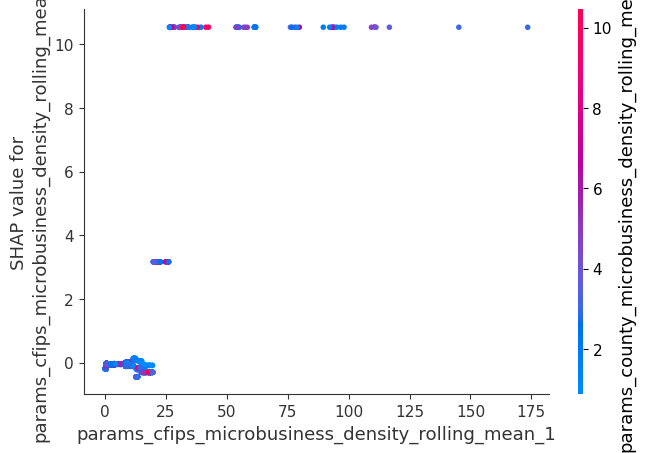

9.067153925013043


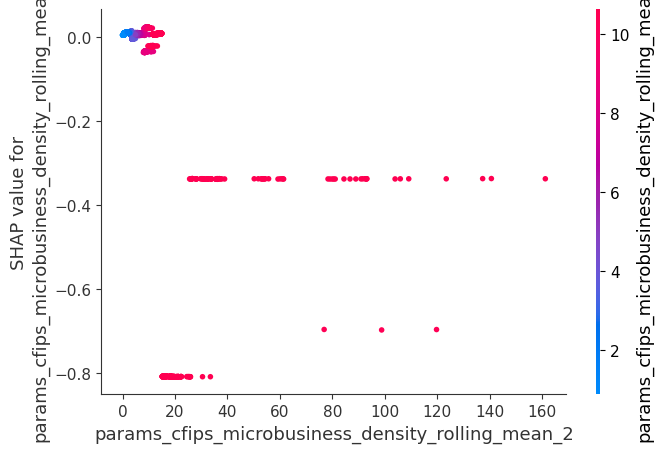

1.2440554063270446


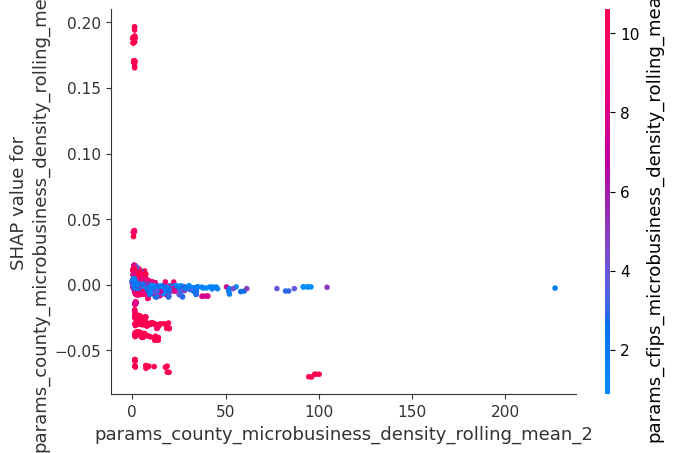

12.309170309175242


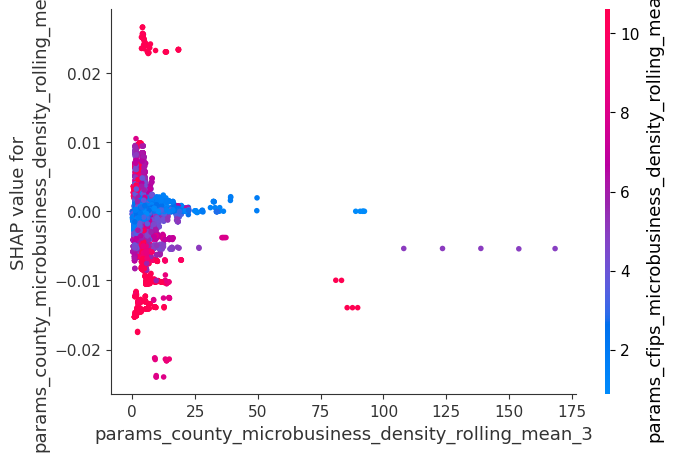

5.503967388465207


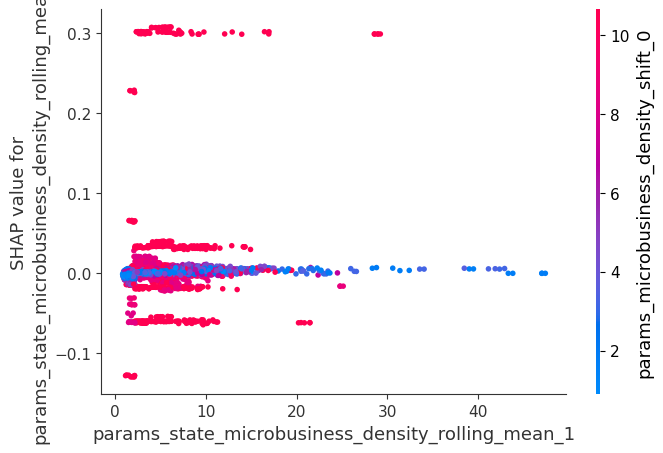

1.0


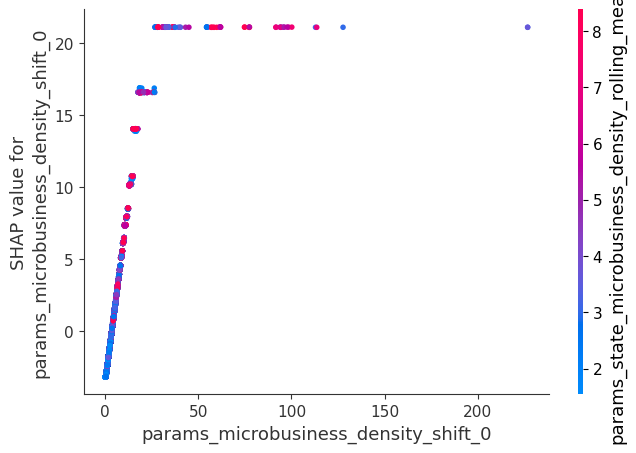

In [16]:
for col in  lgb_test.data.columns:
    if col in optimizer.max['params']:
        print(optimizer.max['params'][col])
    shap.dependence_plot(col, shap_values, lgb_test.data)

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

# New features

In [10]:
# from sklearn.ensemble import IsolationForest
# X = [[-1.1], [0.3], [0.5], [100]]
# clf = IsolationForest(random_state=0).fit(X)
# clf.predict([[0.1], [0], [90]])

array([ 1,  1, -1])

In [6]:
gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks, df_features, df_target = optimize_this_partial(
    return_booster=True, **optimizer.max['params']
)

In [18]:
df_f = df_features.copy()
df_f = df_f.reset_index()
df_f['year'] = df_f['row_id'].str.split('_', expand=True)[1].str.split('-', expand=True)[0]

In [27]:
df_f_na = df_f[df_f.isna().any(axis=1)]
df_f_na['year'].value_counts()

2022    30156
2019    15675
2020    11364
Name: year, dtype: int64

In [33]:
df_f_na[(df_f_na['year'] == '2022') & (~df_f_na['median_hh_inc_target_std'].isna())]

,row_id,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_2,params_microbusiness_density_shift_2,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,state_target_std,median_hh_inc_target_std,pct_college_target_median,pct_college_target_std,pct_foreign_born_target_mean,pct_it_workers_target_median,year
11591,8079_2022-01-01,9.165452,9.037901,13.064356,12.528646,6.091419,7.083437,9.329446,53571.0,91.9,36.0,5.4,3.3,8.029273,0.023722,NaN,NaN,5.175928,3.550635,2022
11592,8079_2022-02-01,9.074344,8.975427,12.943866,12.658784,5.753741,5.519258,9.329446,53571.0,91.9,36.0,5.4,3.3,8.029273,0.023722,NaN,NaN,5.175928,3.550635,2022
11593,8079_2022-03-01,9.037901,9.037901,12.821603,12.770611,7.909421,6.409720,9.475219,53571.0,91.9,36.0,5.4,3.3,8.029273,0.023722,NaN,NaN,5.175928,3.550635,2022
11594,8079_2022-04-01,9.092566,9.162849,12.935006,12.887755,9.590401,7.497166,9.475219,53571.0,91.9,36.0,5.4,3.3,8.029273,0.023722,NaN,NaN,5.175928,3.550635,2022
11595,8079_2022-05-01,9.201895,9.287797,12.906655,12.921618,9.483172,7.876352,9.475219,53571.0,91.9,36.0,5.4,3.3,8.029273,0.023722,NaN,NaN,5.175928,3.550635,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108645,48261_2022-08-01,4.854369,4.854369,2.156314,2.093894,3.228492,3.099699,4.854369,40083.0,50.4,0.4,25.1,0.0,2.620031,0.021924,NaN,NaN,8.125600,1.734012,2022
108646,48261_2022-09-01,4.854369,4.854369,2.143073,2.101040,2.536089,3.041475,4.854369,40083.0,50.4,0.4,25.1,0.0,2.620031,0.021924,NaN,NaN,8.125600,1.734012,2022
108647,48261_2022-10-01,4.854369,4.854369,2.161988,2.110287,2.339254,3.205310,4.854369,40083.0,50.4,0.4,25.1,0.0,2.620031,0.021924,NaN,NaN,8.125600,1.734012,2022
108648,48261_2022-11-01,4.854369,4.854369,2.169554,2.121636,2.225325,3.071589,4.854369,40083.0,50.4,0.4,25.1,0.0,2.620031,0.021924,NaN,NaN,8.125600,1.734012,2022


In [25]:
df_f[df_f.isna().any(axis=1)]['year'].value_counts()

2022    30156
2019    15675
2020    11364
Name: year, dtype: int64

In [17]:
df_features.reset_index()['row_id'].str.split('_', expand=True)[1].str.split('-', expand=True)[0]

0         2019
1         2019
2         2019
3         2019
4         2019
          ... 
128530    2022
128531    2022
128532    2022
128533    2022
128534    2022
Name: 0, Length: 128535, dtype: object

In [19]:
df_features[df_features.isna().any(axis=1)]

,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_2,params_microbusiness_density_shift_2,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,state_target_std,median_hh_inc_target_std,pct_college_target_median,pct_college_target_std,pct_foreign_born_target_mean,pct_it_workers_target_median,year
row_id,,,,,,,,,,,,,,,,,,,
1001_2019-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55317.0,76.6,14.5,2.1,1.3,1.485095,0.058500,2.663940,5.179877,3.539948,2.680268,NaN
1001_2019-09-01,NaN,NaN,1.343837,NaN,NaN,NaN,2.810658,55317.0,76.6,14.5,2.1,1.3,1.485095,0.058500,2.663940,5.179877,3.539948,2.680268,NaN
1001_2019-10-01,NaN,NaN,1.204819,NaN,NaN,NaN,2.695891,55317.0,76.6,14.5,2.1,1.3,1.485095,0.058500,2.663940,5.179877,3.539948,2.680268,NaN
1001_2019-11-01,NaN,NaN,1.266605,NaN,NaN,NaN,2.855664,55317.0,76.6,14.5,2.1,1.3,1.485095,0.058500,2.663940,5.179877,3.539948,2.680268,NaN
1001_2019-12-01,NaN,NaN,1.235712,NaN,NaN,NaN,2.797156,55317.0,76.6,14.5,2.1,1.3,1.485095,0.058500,2.663940,5.179877,3.539948,2.680268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2022-08-01,1.811693,1.810719,0.334821,0.384425,43.832172,30.785298,1.836698,53333.0,79.7,12.7,2.3,0.0,12.688738,0.023857,2.389904,1.474611,3.210552,1.734012,NaN
56045_2022-09-01,1.811693,1.815915,0.334821,0.378224,43.331296,30.701016,1.818512,53333.0,79.7,12.7,2.3,0.0,12.688738,0.023857,2.389904,1.474611,3.210552,1.734012,NaN
56045_2022-10-01,1.816239,1.821110,0.334821,0.372024,47.416130,31.375370,1.818512,53333.0,79.7,12.7,2.3,0.0,12.688738,0.023857,2.389904,1.474611,3.210552,1.734012,NaN


In [38]:
tt = lgb_eval.data.reset_index()
tt['cfips'] = tt['row_id'].str.split('_', expand=True)[0]
tt['date'] = tt['row_id'].str.split('_', expand=True)[1]

In [47]:
df_train[df_train['row_id'].isin()]manage_data_split._test_idx

Index(['1001_2022-08-01', '1001_2022-09-01', '1001_2022-10-01',
       '1001_2022-11-01', '1001_2022-12-01', '1003_2022-08-01',
       '1003_2022-09-01', '1003_2022-10-01', '1003_2022-11-01',
       '1003_2022-12-01',
       ...
       '56043_2022-08-01', '56043_2022-09-01', '56043_2022-10-01',
       '56043_2022-11-01', '56043_2022-12-01', '56045_2022-08-01',
       '56045_2022-09-01', '56045_2022-10-01', '56045_2022-11-01',
       '56045_2022-12-01'],
      dtype='object', name='row_id', length=15675)

In [44]:
tt[tt['cfips'] == '27141']

,row_id,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_2,params_microbusiness_density_shift_2,median_hh_inc,pct_bb,...,pct_foreign_born,pct_it_workers,state_target_std,median_hh_inc_target_std,pct_college_target_median,pct_college_target_std,pct_foreign_born_target_mean,pct_it_workers_target_median,cfips,date
3356,27141_2021-12-01,4.726885,4.729731,0.948464,0.917688,3.948199,4.916188,4.802877,89250.0,89.2,...,3.4,0.9,1.853975,0.063501,4.802877,3.57384,3.602869,2.205368,27141,2021-12-01


In [46]:
df_train[df_train['cfips'] == 27141]

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density
56662,27141_2019-08-01,27141,Sherburne County,Minnesota,2019-08-01,5.110197,3427,MN,2019,83895.0,85.6,19.9,2.9,1.0,8,4.833909
56663,27141_2019-09-01,27141,Sherburne County,Minnesota,2019-09-01,5.201157,3488,MN,2019,83895.0,85.6,19.9,2.9,1.0,9,4.919952
56664,27141_2019-10-01,27141,Sherburne County,Minnesota,2019-10-01,5.186245,3478,MN,2019,83895.0,85.6,19.9,2.9,1.0,10,4.905847
56665,27141_2019-11-01,27141,Sherburne County,Minnesota,2019-11-01,5.226507,3505,MN,2019,83895.0,85.6,19.9,2.9,1.0,11,4.943931
56666,27141_2019-12-01,27141,Sherburne County,Minnesota,2019-12-01,5.058006,3392,MN,2019,83895.0,85.6,19.9,2.9,1.0,12,4.784541
56667,27141_2020-01-01,27141,Sherburne County,Minnesota,2020-01-01,4.933525,3362,MN,2020,85818.0,86.9,19.6,3.3,0.9,1,4.742224
56668,27141_2020-02-01,27141,Sherburne County,Minnesota,2020-02-01,4.823467,3287,MN,2020,85818.0,86.9,19.6,3.3,0.9,2,4.636434
56669,27141_2020-03-01,27141,Sherburne County,Minnesota,2020-03-01,4.851348,3306,MN,2020,85818.0,86.9,19.6,3.3,0.9,3,4.663234
56670,27141_2020-04-01,27141,Sherburne County,Minnesota,2020-04-01,4.882165,3327,MN,2020,85818.0,86.9,19.6,3.3,0.9,4,4.692856
56671,27141_2020-05-01,27141,Sherburne County,Minnesota,2020-05-01,4.912981,3348,MN,2020,85818.0,86.9,19.6,3.3,0.9,5,4.722477


In [45]:
tt[tt['cfips'] == '37155']

,row_id,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_2,params_microbusiness_density_shift_2,median_hh_inc,pct_bb,...,pct_foreign_born,pct_it_workers,state_target_std,median_hh_inc_target_std,pct_college_target_median,pct_college_target_std,pct_foreign_born_target_mean,pct_it_workers_target_median,cfips,date
4778,37155_2021-12-01,1.134995,1.133810,2.612568,3.691431,2.909971,2.463325,1.141044,34976.0,59.1,...,4.2,0.6,3.433569,0.012892,1.618272,3.565815,3.445139,1.854494,37155,2021-12-01
4779,37155_2022-01-01,1.135136,1.136221,4.321056,4.100078,2.846517,2.482535,1.144420,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-01-01
4780,37155_2022-02-01,1.140762,1.142491,5.583081,4.152709,3.078769,2.831802,1.172552,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-02-01
4781,37155_2022-03-01,1.147796,1.149725,1.220363,4.025435,8.822244,6.335833,1.184930,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-03-01
4782,37155_2022-04-01,1.155954,1.158888,0.957545,3.999952,8.750437,6.237262,1.199559,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-04-01
4783,37155_2022-05-01,1.165800,1.170301,2.845673,4.045238,9.329679,6.746451,1.214188,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-05-01
4784,37155_2022-06-01,1.174521,1.180107,0.961177,4.021018,9.270439,6.627410,1.204060,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-06-01
4785,37155_2022-07-01,1.185633,1.192003,1.983890,4.146975,10.809588,7.682071,1.224315,35362.0,63.0,...,4.2,0.6,3.433569,0.058042,1.618272,3.565815,3.445139,1.854494,37155,2022-07-01


In [41]:
df = df_train.copy()
df["outlier"] = IsolationForest(random_state=0).fit_predict(
    df["microbusiness_density"].values.reshape(-1, 1)
)

<Axes: xlabel='microbusiness_density', ylabel='microbusiness_density'>

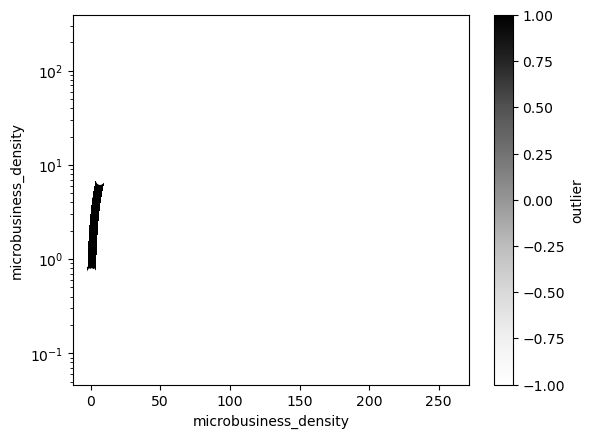

In [24]:
df[["outlier", "microbusiness_density"]].plot.scatter(
    "microbusiness_density", "microbusiness_density", logy=True, c="outlier"
)